# Creating a simple graph database from MovieLens 100K dataset

In this notebook, we are going to create a graph database from MovieLens 100K dataset which can be downloaded from this link: https://www.kaggle.com/rajmehra03/movielens100k#links.csv.

## Data preparation and EDA

In [420]:
import pandas as pd

In [431]:
movies_df = pd.read_csv('/Users/justinnaing/Workspace/MDSI/datasets/movielens100k/movies.csv')
ratings_df = pd.read_csv('/Users/justinnaing/Workspace/MDSI/datasets/movielens100k/ratings.csv')

### Extract year from movie title

In [432]:
import re
def get_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match: return match.group(1)

In [433]:
def strip_year_off(title):
    return [_.strip() for _ in re.compile('\((\d{4})\)').split(title) if _][0]

In [434]:
movies_df['year'] = movies_df['title'].apply(get_year)

In [435]:
movies_df['title'] = movies_df['title'].apply(strip_year_off)

In [436]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [437]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### Merge raings and movies dataframes

In [438]:
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

In [439]:
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,31,2.5,1260759144,Dangerous Minds,Drama,1995
1,7,31,3.0,851868750,Dangerous Minds,Drama,1995
2,31,31,4.0,1273541953,Dangerous Minds,Drama,1995
3,32,31,4.0,834828440,Dangerous Minds,Drama,1995
4,36,31,3.0,847057202,Dangerous Minds,Drama,1995


In [440]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 7 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
title        100004 non-null object
genres       100004 non-null object
year         99997 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 6.1+ MB


### Split rows by genres

In [445]:
melted_genre_df = (movies_df['genres'].apply(lambda genres: genres.split('|')).apply(pd.Series)
    .merge(movies_df, right_index=True, left_index=True)
    .drop('genres', axis='columns')
    .melt(id_vars=['title', 'movieId', 'year'], value_name='genre')
    .drop('variable', axis='columns')
    .dropna())

In [447]:
melted_genre_df.head()

,title,movieId,year,genre
0,Toy Story,1,1995,Adventure
1,Jumanji,2,1995,Adventure
2,Grumpier Old Men,3,1995,Comedy
3,Waiting to Exhale,4,1995,Comedy
4,Father of the Bride Part II,5,1995,Comedy


### Genres for all movies

In [448]:
import matplotlib.pyplot as plt

<BarContainer object of 20 artists>

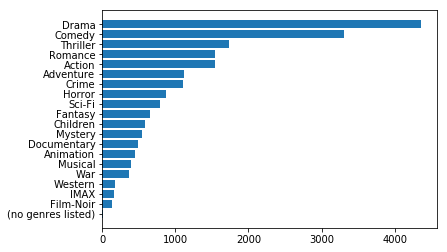

In [450]:
genres_count = melted_genre_df.groupby(by='genre')['genre'].count().sort_values()
plt.barh(genres_count.keys(), genres_count.values)

### Top rated movies

<BarContainer object of 20 artists>

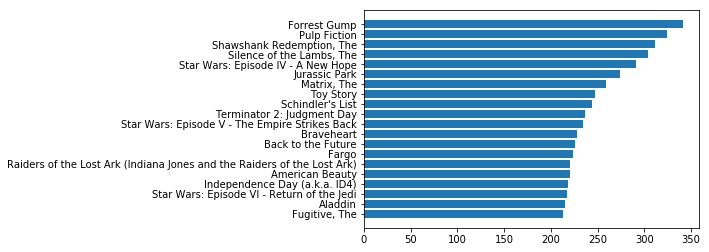

In [451]:
top_20_rated = merged_df.groupby(by='title')['title'].count().sort_values()[-20:]
plt.barh(top_20_rated.keys(), top_20_rated.values)

## Create the Graph database

In [452]:
from py2neo import Graph
graph = Graph(password="12345")

In [453]:
graph.delete_all()

### Create Movie nodes

In [454]:
create_movie_query = """
UNWIND {rows} as row
MERGE (m:Movie {movieId: row.movieId})
  ON CREATE SET m.title = row.title, m.year = row.year
"""

In [455]:
graph.run(create_movie_query, rows=list(movies_df.T.to_dict().values()))

Check the movies

In [456]:
graph.run("""
MATCH (m:Movie)
RETURN m.title as movieTitle, m.movieId as id, m.year as year
LIMIT 5
""").to_table()

movieTitle,id,year
Casino,16,1995
Sense and Sensibility,17,1995
Four Rooms,18,1995
Ace Ventura: When Nature Calls,19,1995
Money Train,20,1995


### Create Genre nodes

In [457]:
create_genre_query = """
UNWIND {rows} as genre
CREATE (:Genre {genre: genre})
"""

In [458]:
graph.run(create_genre_query, rows=list(melted_genre_df['genre'].unique()))

Check the created genre nodes

In [459]:
graph.run("""
MATCH (g:Genre)
RETURN g.genre as genre
LIMIT 30
""").to_table()

genre
Adventure
Comedy
Action
Drama
Crime
Children
Mystery
Documentary
Animation
Thriller


### Create relationshiop between movie and genres

In [460]:
query = """
UNWIND {rows} as row
MATCH (m:Movie), (g:Genre)
WHERE m.movieId = row.movieId and g.genre = row.genre
CREATE (g)-[:IS_GENRE_OF]->(m)
"""

In [461]:
graph.run(query, rows=list(melted_genre_df.T.to_dict().values()))

Finally, we have a graph with movies and genres connected with IS_GENRE_OF relationship.

![alttext](./images/movies_genres.png "Movies Genres")